# Plume Analysis Georgia

In [248]:
%matplotlib inline
%reset -f
import fnmatch
import scipy.optimize as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import glob
from IPython.display import set_matplotlib_formats
from scipy.optimize import curve_fit
import re
import datetime as dt 
import scipy.signal
import matplotlib.ticker as mticker
import math
from IPython.display import display, Latex
import statistics

# %config InlineBackend.figure_formats = ['svg']
plt.rcParams['savefig.dpi'] = 350
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 1.
plt.rcParams['figure.dpi'] = 100

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

In [249]:
def plume_analysis_new(df):
    data_Y=df['Points:1'].values; data_Z=df['Points:2'].values #not height
    dim=int(np.sqrt(len(df['temperature'])))
    T_blocks = np.reshape(df['temperature'].to_numpy(),(dim,dim))
    U_blocks = np.reshape(df['velocity:0'].to_numpy(),(dim,dim))
    Y_blocks = np.reshape(df['Points:1'].to_numpy(),(dim,dim))
    Z_blocks = np.reshape(df['Points:2'].to_numpy(),(dim,dim))
 
    max_temp=np.max(T_blocks); avg_temp=np.mean(T_blocks); thd_temp=avg_temp+0.2*(max_temp-avg_temp)

    P_blocks=np.zeros((256,256)) #Location of plumes. 1 = plume, 0 = no plume
    P_blocks[:] = np.nan
    T_p_blocks=np.zeros((256,256)) #Only plume temperature. 1 = plume, 0 = no plume
    T_p_blocks[:] = np.nan

    
    da=(data_Y[1]-data_Y[0])**2 #area

    pmf=0; phf=0; plume_temp=[]; plume_cells=0; 
    ypoints1 = []; zpoints2 = [];

    for i in range(dim-1):
        for j in range(dim-1):
            if (T_blocks[i,j]>=thd_temp) and (U_blocks[i,j]>0):
                plume_cells+=1
                plume_temp.append(T_blocks[i,j])
                ypoints1.append(Y_blocks[i,j])
                zpoints2.append(Z_blocks[i,j])
                P_blocks[i,j]=1
                T_p_blocks[i,j]=T_blocks[i,j]
                pmf+=U_blocks[i,j]*da
                phf+=U_blocks[i,j]*(T_blocks[i,j]-avg_temp)*da

    plume_temp_mean=np.sum(plume_temp)/plume_cells
    maxTp = np.max(plume_temp)
    minTp = np.min(plume_temp)
    sd = statistics.stdev(plume_temp)
    return maxTp, plume_temp_mean, plume_temp, P_blocks, T_p_blocks, dim, minTp, sd, ypoints1, zpoints2

In [259]:
plume_path = '\\Plume Data'

main_path = 'C:\\Users\\super\\Dropbox\\Rice University\\501\\BL_Interactions\\'
fname = os.path.join(main_path,'[!m]*')
fileL = glob.glob(fname) #list of files
fileL = [file.replace(main_path,'') for file in fileL]
[fileL.remove(file) for file in fileL if '_' in file]; [fileL.remove(file) for file in fileL if 'Plume' in file];
ra_path = sorted (fileL, key = lambda x: (len (x), x))
lenRa = len(ra_path)

Data = pd.DataFrame()

for i in range(lenRa):    
    fname = os.path.join(main_path+ra_path[i]+'\\Plume Data','500.csv')
    fileL = glob.glob(fname) #list of files
    temp = []
    for file in fileL:
        a = fileL.index(file)
        b = pd.read_csv(file,header=0)
        b.rename(columns={0:a}, inplace=True)
        temp.append(b)
    c = b['temperature'].copy()
    c.values[:] = ra_path[i]
    temp.append(c)

    my_data = pd.concat(temp, axis=1, join="inner",ignore_index=True).drop([2,3,4],axis=1)
    my_data.rename(columns={0:'temperature',5:'Points:1',6:'Points:2',7:'Ra',1:'velocity:0'},inplace=True)
    Data = pd.concat([Data,my_data],ignore_index=True)
Data['Ra'] = Data['Ra'].astype(float)
Data = Data.sort_values(by=['Ra','Points:2','Points:1'])
Data = Data.reset_index(drop=True)

In [275]:
RaU = Data.Ra.unique()
abc = 2
data = [[] for i in range(lenRa-abc)] #empty nested list

for i in range(lenRa-abc):
    data[i] = Data.loc[Data['Ra'] == RaU[i]]
    data[i] = data[i].reset_index(drop=True)
    
plumeData = pd.DataFrame(columns=['Ra', 'Z', 'T_p'],index=range(0, lenRa-6))

for i in range(lenRa-abc):
    plumeData.at[i, 'Ra'] = RaU[i]
    pa = plume_analysis_new(data[i])
    plumeData.at[i, 'Z'] = 0.5
    plumeData.at[i, 'T_p'] = pa[1]
    plumeData.at[i, 'max_T_p'] = pa[0]
    plumeData.at[i, 'min_T_p'] = pa[6]
    plumeData.at[i, 'Std. Dev.'] = pa[7]
    dim = pa[5]

# plumeData = plumeData.sort_values(by=['Ra'])
# plumeData = plumeData.reset_index(drop=True) 
plumeData

,Ra,Z,T_p,max_T_p,min_T_p,Std. Dev.
0,10000.0,0.5,0.684158,0.87206,0.57441,0.084390
1,100000.0,0.5,0.705302,0.91947,0.58395,0.094379
2,1000000.0,0.5,0.720129,0.95297,0.59095,0.101761
3,3000000.0,0.5,0.668377,0.75046,0.56211,0.058956
4,10000000.0,0.5,0.663939,0.83452,0.57171,0.056920
5,30000000.0,0.5,0.652595,0.73534,0.55808,0.061497
6,100000000.0,0.5,0.674639,0.89425,0.57915,0.067138
7,300000000.0,0.5,0.659486,0.78178,0.57472,0.039583
8,600000000.0,0.5,0.674736,0.92477,0.58582,0.076570
9,1000000000.0,0.5,0.679703,0.98323,0.59563,0.087596


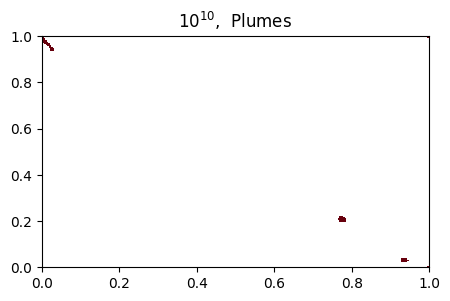

In [276]:
x = np.reshape(data[i]['Points:1'].to_numpy(),(dim,dim))
y = np.reshape(data[i]['Points:2'].to_numpy(),(dim,dim))
plt.pcolormesh(x, y, pa[3], vmin=0,vmax=1, cmap='Reds');
plt.title('{}'.format(fmt(float(RaU[i])))+',  Plumes');
# display(Latex('{}'.format(fmt(float(RaU[i])))))

In [265]:
import pandas as pd
import plotly.express as px
import hvplot.pandas
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [266]:
x = np.vstack((pa[8], pa[9])).T
df2 = pd.DataFrame(x)

In [267]:
inertia = [] #empty list to hold inertia values
k = list(range(1, 11)) #store a range of K values we want to test

for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df2)
    inertia.append(km.inertia_)
    
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

:Curve   [k]   (inertia)

In [268]:
x = np.vstack((pa[8], pa[9])).T
df2 = pd.DataFrame(x)
k = 10
model = KMeans(n_clusters=k, random_state=4)
model.fit(df2)
predictions = model.predict(df2)
df2["class"] = model.labels_
df2.head()

,0,1,class
0,0.48828,0.34375,4
1,0.49219,0.34766,4
2,0.49609,0.34766,4
3,0.49609,0.35156,4
4,0.50000,0.35156,4


In [269]:
predictions

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8,
       8, 8, 8, 8, 8, 0, 0, 8, 8, 8, 8, 8, 0, 0, 0, 0, 8, 8, 8, 8, 0, 0,
       0, 0, 0, 0, 7, 8, 8, 8, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 9, 9, 8,
       0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 3, 9, 9, 9, 9, 9, 2, 2,
       2, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 9, 9, 9, 2,
       2, 2, 2, 0, 0, 0, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2,
       7, 7, 7, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5])

In [270]:
import plotly.express as px
import hvplot.pandas

In [271]:
df2.hvplot.scatter(x="0", y="1", by="class", size=5)

:NdOverlay   [class]
   :Scatter   [0]   (1)

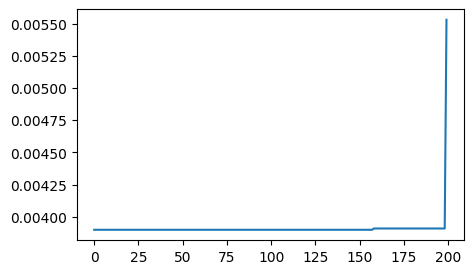

In [272]:
from sklearn.neighbors import NearestNeighbors # importing the library
xx = pd.DataFrame(np.vstack((pa[8], pa[9])).T)
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(xx) # fitting the data to the object
distances,indices=nbrs.kneighbors(xx) # finding the nearest neighbours

# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances); # plotting the distances
# plt.ylim(0,0.04)

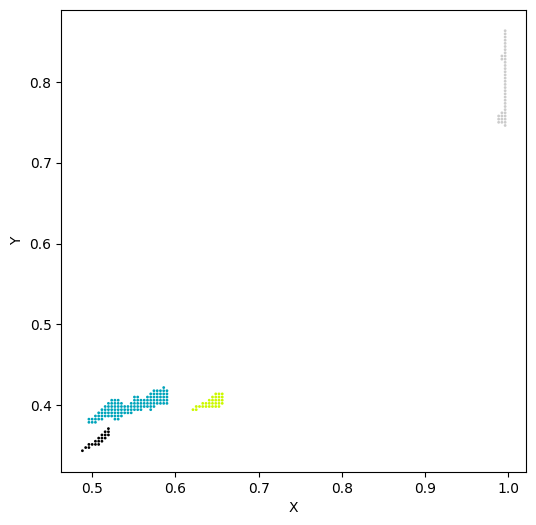

In [273]:
from sklearn.cluster import DBSCAN
# cluster the data into five clusters
dbscan = DBSCAN(eps = 0.006, min_samples = 3).fit(xx) # fitting the model
labels = dbscan.labels_ # getting the labels

fig = plt.figure(figsize=(6,6))
# Plot the clusters
plt.scatter(xx[0], xx[1], c = labels, cmap= "nipy_spectral") # plotting the clusters
plt.xlabel("X") # X-axis label
plt.ylabel("Y") # Y-axis label
plt.show() # showing the plot

In [274]:
xx["class"] = labels
xx = xx[xx['class'] != -1]
xx.hvplot.scatter(x="0", y="1", by="class", size=15)

:NdOverlay   [class]
   :Scatter   [0]   (1)

In [233]:
deltaT(plumeData['Ra'].iloc[-1])

7848.118368223776

In [234]:
[ tt * deltaT(plumeData['Ra'].iloc[-1]) for tt in meanPlumeTemp1 ]

[5494.505849628771,
 5095.210805500838,
 4949.530767796429,
 4912.683636449971,
 5059.149711467024,
 4686.785107826356,
 5162.323226221975,
 4982.60466948639,
 4833.9700277237525,
 5525.016470341777]

The number of plumes is 9


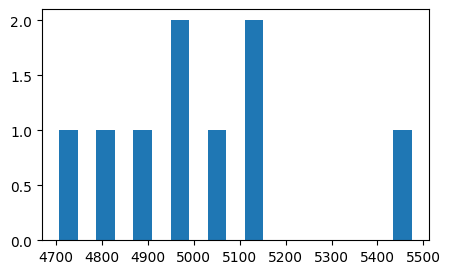

In [247]:
num_of_plumes = np.max(np.unique(labels))
print('The number of plumes is',num_of_plumes)
meanPlumeTemp1 = []
for m in range(num_of_plumes):
    idx = np.where(labels==m)[0]
    ptemp = np.array(pa[2])
    meanPlumeTemp1.append(ptemp[idx].mean())
meanPlumeTemp1
plt.hist([ tt * deltaT(plumeData['Ra'].iloc[-1]) for tt in meanPlumeTemp1 ], rwidth=0.5);

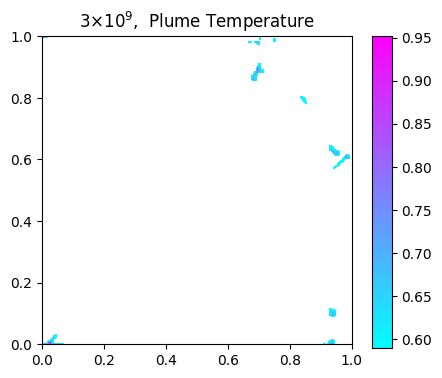

In [211]:
fig = plt.figure(figsize=(4,4))
im = plt.pcolormesh(x, y, pa[4], cmap='cool');
plt.title('{}'.format(fmt(float(RaU[i])))+',  Plume Temperature');
cb_ax = fig.add_axes([0.95,0.1,.05,0.78])
fig.colorbar(im,orientation='vertical',cax=cb_ax);

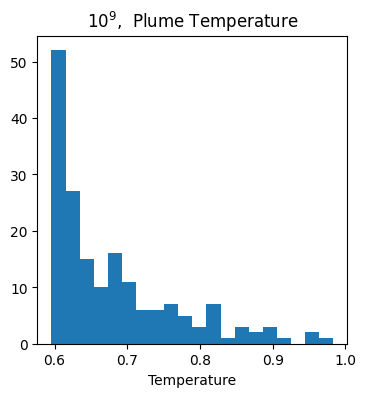

In [167]:
plt.hist(pa[2],20);
plt.xlabel('Temperature');
plt.title('{}'.format(fmt(float(RaU[i])))+',  Plume Temperature');
# plt.yscale('log');

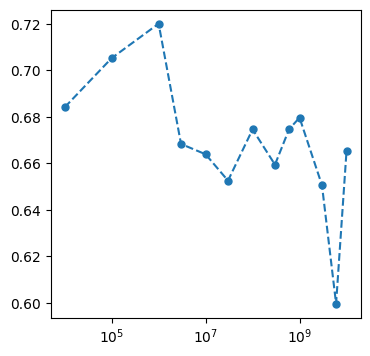

In [10]:
plt.rcParams['lines.markersize'] = 10.
plt.plot(plumeData['Ra'],plumeData['T_p'],'.--')
plt.xscale('log');

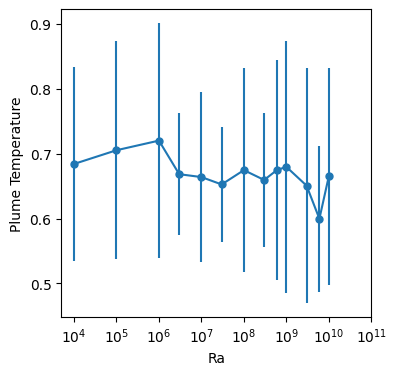

In [11]:
plt.rcParams['lines.markersize'] = 5.
midpoint = (plumeData['max_T_p']+plumeData['min_T_p'])/2
error = [midpoint-plumeData['min_T_p'],plumeData['max_T_p']-midpoint]
plt.errorbar(plumeData['Ra'],plumeData['T_p'], yerr=error, fmt='-o')
plt.xscale('log');
plt.xlabel('Ra')
plt.ylabel('Plume Temperature');
plt.xticks(np.logspace(4,11,num=8));

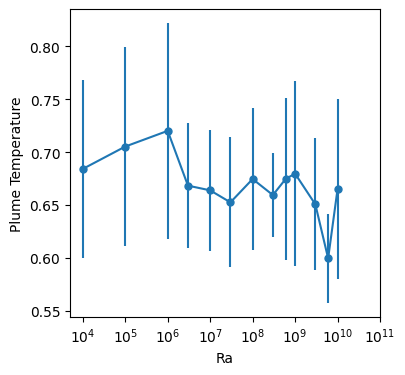

In [13]:
plt.rcParams['lines.markersize'] = 5.
plt.errorbar(plumeData['Ra'],plumeData['T_p'], yerr=plumeData['Std. Dev.'], fmt='-o')
plt.xscale('log');
plt.xlabel('Ra')
plt.ylabel('Plume Temperature');
plt.xticks(np.logspace(4,11,num=8));

In [14]:
R0 = 2870000.0; # m
rho = 3300 # kg/m^3
g = 9.8 # m/s^2
alpha = 5e-5 # 1/K
eta = 10**20 # Pa s
cp = 1250 # J/(kg K)
kappa = 1e-6; # m^2/s
k = kappa*rho*cp; # W/m

In [15]:
def deltaT(Ra):
    tt = (Ra*eta*kappa)/(rho*g*alpha*R0**3)
    return tt

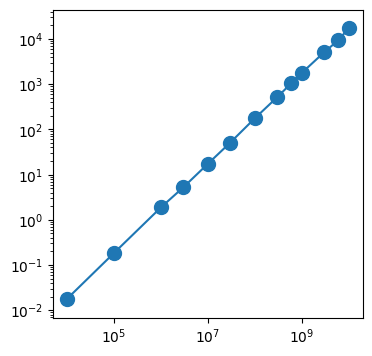

In [16]:
plt.rcParams['lines.markersize'] = 10.
midpoint = deltaT(plumeData['Ra'])*(plumeData['max_T_p']+plumeData['min_T_p'])/2
error = [midpoint-plumeData['min_T_p']*deltaT(plumeData['Ra']),plumeData['max_T_p']*deltaT(plumeData['Ra'])-midpoint]
plt.errorbar(plumeData['Ra'],plumeData['T_p']*deltaT(plumeData['Ra']), yerr=error, fmt='-o')
plt.xscale('log');
plt.yscale('log');

Get the plume temperatures, mean and standard deviation.
Plot Ra in x, mean plume temp in y with std dev error bars or with  min and max

Try to dimensionalize them